In [238]:
import numpy as np
import pandas as pd
import sys 
sys.path.insert(0, '/home/toque/work/forecast/utils/')
import utils
import utils_date

import itertools
from multiprocessing import cpu_count
from joblib import Parallel
from joblib import delayed
from warnings import catch_warnings
from warnings import filterwarnings
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt

from statsmodels.tsa.statespace import sarimax

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ExponentialSmoothing

import seaborn
seaborn.set_style('whitegrid')

In [175]:
def create_Yendog_exog(start, end, obs, fea):
    date_list = utils_date.get_list_common_date(start, end, obs, [fea])
    
    Yendog = obs.set_index('Datetime').loc[date_list].values
    exog = fea.set_index('Datetime').loc[date_list].values
    mask = (exog!=0).sum(axis=0)!=0
    
    exog = exog[:,mask]
    Yendog_name_list = obs.set_index('Datetime').columns.values
    exog_name_list = fea.set_index('Datetime').columns.values[mask]
    
    return Yendog, exog, Yendog_name_list, exog_name_list

# root mean squared error or rmse
def measure_rmse(obs, pred):
    return sqrt(mean_squared_error(obs, pred))

# Try to forecast per TIMESTEP of 15 minutes
The week frequency (periodicity = 7\*96) is too long to take into account. 

We have to try the forecast of the number of passenger entering the network with an aggregation per **DAY**

## Data

In [176]:
obs_path = ['/home/toque/data2/montreal/stm/data/valid_metro_15min_2015_2016_2017_sumpass_nodayfree.csv']
fea_path = ['/home/toque/data2/date/2013-01-01-2019-01-01_new.csv',
            '/home/toque/data2/montreal/events/data/clean/events_2015_2018_start_event_stopid.csv',
            '/home/toque/data2/montreal/events/data/clean/events_2015_2018_end_event_stopid.csv',
            '/home/toque/data2/montreal/events/data/clean/events_2015_2018_period_event_stopid.csv',
           ]

obs = utils.read_csv_list(obs_path)
fea = utils.read_csv_list(fea_path)

# Add timesteps to obs to have 96 timesteps per day
day_list = sorted(list(set([i[:10] for i in obs['Datetime'].values])))
time_step_list = list(np.array([utils_date.build_timestamp_list(day+' 00:00:00', day+ ' 23:45:00',time_step_second=15*60) for day in day_list]).flatten())
df = pd.DataFrame(data=time_step_list, columns=['Datetime'])
obs = df.set_index('Datetime').join(obs.set_index('Datetime')).fillna(0).reset_index()

In [177]:
features_todummy = ['Day_en', 'Mois', 'hms_int_15min']

features_nottodummy = ['24DEC', '31DEC', 'day_off_quebec', 'renov_beaubien', 
                       'vac_udem1', 'vac_udem2', 'vac_noel_quebec', 'Year']

time_series = ['11', '32', '34', '15', '44', '65', '31', '33', '35', '47', '13',
       '14', '1', '9', '5', '18', '36', '24', '68', '43', '8', '64', '10',
       '55', '3', '49', '51', '2', '19', '56', '7', '6', '4', '48', '66',
       '25', '23', '28', '39', '54', '60', '27', '20', '46', '12', '21',
       '62', '52', '41', '50', '30', '16', '37', '40', '26', '67', '57',
       '61', '42', '45', '38', '29', '58', '63', '22', '59', '53', '17']

time_series = ['32']

fea = fea[['Datetime'] + features_todummy + features_nottodummy]
for f in features_todummy:
    d = pd.get_dummies(fea[f])
    fea = pd.concat([fea, d], axis=1)   
    fea.drop([f, d.columns.values[-1]], inplace=True, axis=1)
    
obs = obs.set_index('Datetime')[time_series].reset_index()

## SARIMAX

In [178]:
start_train = '2015-01-01'
end_train = '2015-01-15'
end_val = '2015-02-21'

Yendog, exog, Yendog_name_list, exog_name_list = create_Yendog_exog(start_train, end_val, obs, fea)


index_train = len(utils_date.get_list_common_date(start_train, end_train, obs, [fea]))
Yendog_train, Yendog_val = Yendog[:index_train], Yendog[index_train:]
exog_train, exog_val = exog[:index_train], exog[index_train:]

### Periodicity = 1

In [83]:
%%time
order = (2, 1, 0)
seasonal_order = (1, 0, 0, 1)
trend = 'n'

model = sarimax.SARIMAX(Yendog_train ,exog=exog_train, order=order, seasonal_order=seasonal_order, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
model_fit = model.fit(disp=1, maxiter=1)

/opt/conda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


CPU times: user 8.4 s, sys: 84.1 ms, total: 8.48 s
Wall time: 2.12 s


RMSE error = 215.62


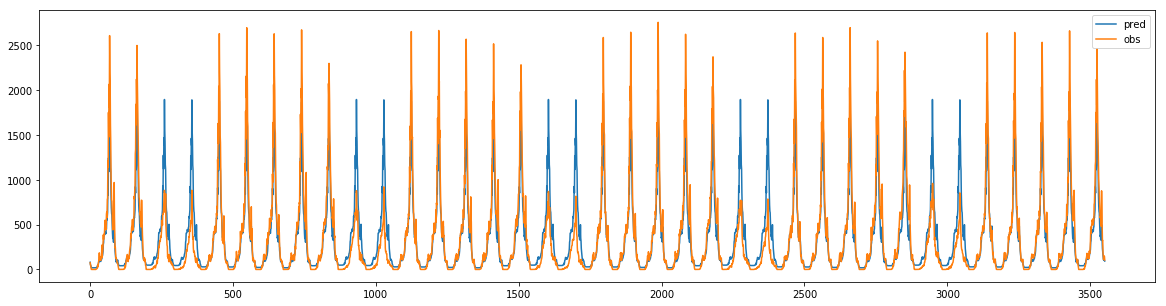

In [84]:
res = model_fit.predict(start=len(Yendog_train), end=len(Yendog_train)+len(Yendog_val)-1, exog=exog_val)

print('RMSE error = {:.2f}'.format(measure_rmse(Yendog_val,res)))
fig,ax = plt.subplots(figsize=(20,5))
plt.plot(res, label='pred')
plt.plot(Yendog_val, label='obs')
plt.legend()
plt.show()


### Periodicity = 96 (day)

In [59]:
%%time
order = (2, 1, 0)
seasonal_order = (1, 0, 0, 96)
trend = 'n'

model = sarimax.SARIMAX(Yendog_train ,exog=exog_train, order=order, seasonal_order=seasonal_order, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
model_fit = model.fit(disp=1, maxiter=1)

/opt/conda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


CPU times: user 6min 42s, sys: 248 ms, total: 6min 42s
Wall time: 1min 40s


RMSE error = 215.27


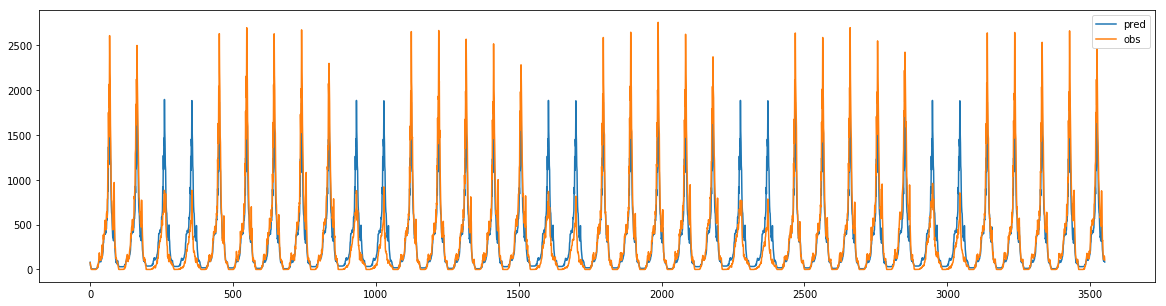

In [81]:
res = model_fit.predict(start=len(Yendog_train), end=len(Yendog_train)+len(Yendog_val)-1, exog=exog_val)

print('RMSE error = {:.2f}'.format(measure_rmse(Yendog_val,res)))
fig,ax = plt.subplots(figsize=(20,5))
plt.plot(res, label='pred')
plt.plot(Yendog_val, label='obs')
plt.legend()
plt.show()


### Periodicity = 7*96 (week) 
Too long to learn 

In [89]:
%%time
order = (2, 1, 0)
seasonal_order = (1, 0, 0, 7*96)
trend = 'n'

model = sarimax.SARIMAX(Yendog_train ,exog=exog_train, order=order, seasonal_order=seasonal_order, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
model_fit = model.fit(disp=1, maxiter=1,)

KeyboardInterrupt: 

In [ ]:
res = model_fit.predict(start=len(Yendog_train), end=len(Yendog_train)+len(Yendog_val)-1, exog=exog_val)

print('RMSE error = {:.2f}'.format(measure_rmse(Yendog_val,res)))
fig,ax = plt.subplots(figsize=(20,5))
plt.plot(res, label='pred')
plt.plot(Yendog_val, label='obs')
plt.legend()
plt.show()

----

# Try to forecast with data agregated per DAY


We try the forecast of the number of passenger entering the network with an aggregation per **DAY**

## Data

In [183]:
obs_path = ['/home/toque/data2/montreal/stm/data/valid_metro_15min_2015_2016_2017_sumpass_nodayfree.csv']
fea_path = ['/home/toque/data2/date/2013-01-01-2019-01-01_new.csv',
            '/home/toque/data2/montreal/events/data/clean/events_2015_2018_start_event_stopid_aggdaily.csv',
            '/home/toque/data2/montreal/events/data/clean/events_2015_2018_end_event_stopid_aggdaily.csv',
            '/home/toque/data2/montreal/events/data/clean/events_2015_2018_period_event_stopid_aggdaily.csv',
           ]

obs = utils.read_csv_list(obs_path)
fea = utils.read_csv_list(fea_path)

obs['Datetime'] = [i[:10]+' 00:00:00' for i in obs['Datetime'].values]
obs = obs.groupby('Datetime').sum().reset_index()

In [184]:
features_todummy = ['Day_en', 'Mois']

features_nottodummy = ['24DEC', '31DEC', 'day_off_quebec', 'renov_beaubien', 
                       'vac_udem1', 'vac_udem2', 'vac_noel_quebec', 'Year']

time_series = ['11', '32', '34', '15', '44', '65', '31', '33', '35', '47', '13',
       '14', '1', '9', '5', '18', '36', '24', '68', '43', '8', '64', '10',
       '55', '3', '49', '51', '2', '19', '56', '7', '6', '4', '48', '66',
       '25', '23', '28', '39', '54', '60', '27', '20', '46', '12', '21',
       '62', '52', '41', '50', '30', '16', '37', '40', '26', '67', '57',
       '61', '42', '45', '38', '29', '58', '63', '22', '59', '53', '17']

time_series = ['32']

fea = fea[['Datetime'] + features_todummy + features_nottodummy]
for f in features_todummy:
    d = pd.get_dummies(fea[f])
    fea = pd.concat([fea, d], axis=1)   
    fea.drop([f, d.columns.values[-1]], inplace=True, axis=1)
    
obs = obs.set_index('Datetime')[time_series].reset_index()

## SARIMAX

In [185]:
start_train = '2015-01-01'
end_train = '2017-01-01'
end_val = '2018-01-01'

Yendog, exog, Yendog_name_list, exog_name_list = create_Yendog_exog(start_train, end_val, obs, fea)


index_train = len(utils_date.get_list_common_date(start_train, end_train, obs, [fea]))
Yendog_train, Yendog_val = Yendog[:index_train], Yendog[index_train:]
exog_train, exog_val = exog[:index_train], exog[index_train:]

### Periodicity = 1 (day)

In [186]:
%%time
order = (11, 0, 0)
seasonal_order = (1, 0, 0, 1)
trend = 'ct'

model = sarimax.SARIMAX(Yendog_train ,exog=exog_train, order=order, seasonal_order=seasonal_order, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
model_fit = model.fit(disp=1, maxiter=1)

CPU times: user 2.13 s, sys: 28 ms, total: 2.16 s
Wall time: 541 ms


/opt/conda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


RMSE error = 3148.99


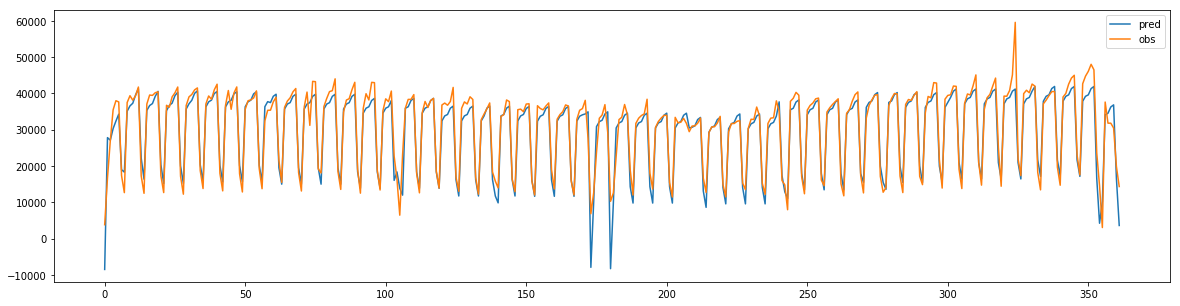

In [188]:
res = model_fit.predict(start=len(Yendog_train), end=len(Yendog_train)+len(Yendog_val)-1, exog=exog_val)

print('RMSE error = {:.2f}'.format(measure_rmse(Yendog_val,res)))
fig,ax = plt.subplots(figsize=(20,5))
plt.plot(res, label='pred')
plt.plot(Yendog_val, label='obs')
plt.legend()
plt.show()


### Periodicity = 7 (week)

In [189]:
%%time
order = (11, 0, 0)
seasonal_order = (1, 0, 0, 7)
trend = 'ct'

model = sarimax.SARIMAX(Yendog_train ,exog=exog_train, order=order, seasonal_order=seasonal_order, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
model_fit = model.fit(disp=1, maxiter=1)

/opt/conda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


CPU times: user 2.95 s, sys: 12 ms, total: 2.97 s
Wall time: 742 ms


RMSE error = 3142.52


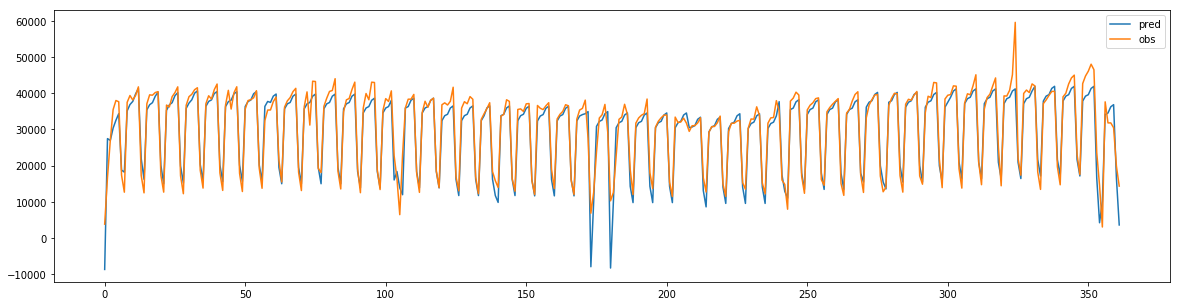

In [191]:
res = model_fit.predict(start=len(Yendog_train), end=len(Yendog_train)+len(Yendog_val)-1, exog=exog_val)

print('RMSE error = {:.2f}'.format(measure_rmse(Yendog_val,res)))
fig,ax = plt.subplots(figsize=(20,5))
plt.plot(res, label='pred')
plt.plot(Yendog_val, label='obs')
plt.legend()
plt.show()


In [193]:
%%time
order = (11, 0, 0)
seasonal_order = (7, 0, 0, 1)
trend = 'ct'

model = sarimax.SARIMAX(Yendog_train ,exog=exog_train, order=order, seasonal_order=seasonal_order, trend=trend, enforce_stationarity=False, enforce_invertibility=False)
model_fit = model.fit(disp=1, maxiter=1)

/opt/conda/envs/py35/lib/python3.5/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


CPU times: user 4.78 s, sys: 44 ms, total: 4.82 s
Wall time: 1.21 s


RMSE error = 3139.69


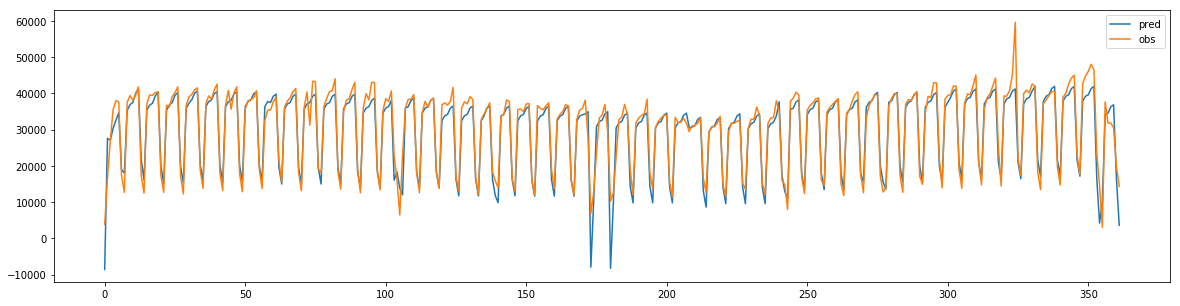

In [194]:
res = model_fit.predict(start=len(Yendog_train), end=len(Yendog_train)+len(Yendog_val)-1, exog=exog_val)

print('RMSE error = {:.2f}'.format(measure_rmse(Yendog_val,res)))
fig,ax = plt.subplots(figsize=(20,5))
plt.plot(res, label='pred')
plt.plot(Yendog_val, label='obs')
plt.legend()
plt.show()


# Functions to optimise the hyperparameters of the SARIMAX model

In [70]:
# grid search configs
def grid_search(Yendog_train, Yendog_val, exog_train, exog_val, cfg_list, n_jobs=False, parallel=True):
    if n_jobs==False:
        n_jobs = cpu_count()
    scores = None
    if parallel:
        # execute configs in parallel
        executor = Parallel(n_jobs=n_jobs, backend='multiprocessing')
        tasks = (delayed(score_model)(Yendog_train, Yendog_val, exog_train, exog_val, cfg, debug=True) for cfg in cfg_list)
        scores = executor(tasks)
    else:
        scores = [score_model(Yendog_train, Yendog_val, exog_train, exog_val, cfg) for cfg in cfg_list]
    # remove empty results
    scores = [r for r in scores if r[1] != None]
    # sort configs by error, asc
    scores.sort(key=lambda tup: tup[1])
    return scores

# score a model, return None on failure
def score_model(Yendog_train, Yendog_val, exog_train, exog_val, cfg, debug=False):
    result = None
    key = str(cfg)
    # show all warnings and fail on exception if debugging
    if debug:
        result = fit_and_predict(Yendog_train, Yendog_val, exog_train, exog_val, cfg)
    else:
        # one failure during model validation suggests an unstable config
        try:
            # never show warnings when grid searching, too noisy
            with catch_warnings():
                filterwarnings("ignore")
                print('warnings')
                result = fit_and_predict(Yendog_train, Yendog_val, exog_train, exog_val, cfg)
        except:
            print('error')
            error = None
    # check for an interesting result
    if result is not None:
        print(' > Model[{}] {:.2f}'.format(key, result))
    return (key, result)

# fit_and_predict
def fit_and_predict(Yendog_train, Yendog_val, exog_train, exog_val, cfg):
    order, sorder, trend = cfg
    model = sarimax.SARIMAX(Yendog_train.flatten(), exog_train, order=order, seasonal_order=sorder, trend=trend,
                            enforce_stationarity=False, enforce_invertibility=False)
    model_fit = model.fit(disp=5)
    predictions = model_fit.predict(start=len(Yendog_train), end=len(Yendog_train)+len(Yendog_val)-1, exog=exog_val)
    print('hello')
    plt.plot(predictions, label ='pred')
    plt.plot(Yendog_val.flatten(), label ='obs')
    plt.legend()
    plt.show()
    
    error = measure_rmse(Yendog_val.flatten(), predictions)

    return error




def sarima_configs():
    p_params = [0, 1, 2]
    d_params = [0, 1]
    q_params = [0, 1, 2]

    P_params = [0, 1, 2]
    D_params = [0, 1]
    Q_params = [0, 1, 2]
    m_params = [0, 7*96]
    
    t_params = ['n','c','t','ct']
        
    p_params = [1]
    d_params = [1]
    q_params = [0]

    P_params = [1]
    D_params = [0]
    Q_params = [0]
    m_params = [1]
    
    t_params = ['t']

    configs = [[(i[0],i[1],i[2]), (i[3],i[4],i[5],i[6]), i[7]] for i in itertools.product(*[p_params, d_params,
                                                                                            q_params, P_params,
                                                                                            D_params, Q_params,
                                                                                            m_params, t_params,])]
    return configs

# SARIMAX - Optimisation

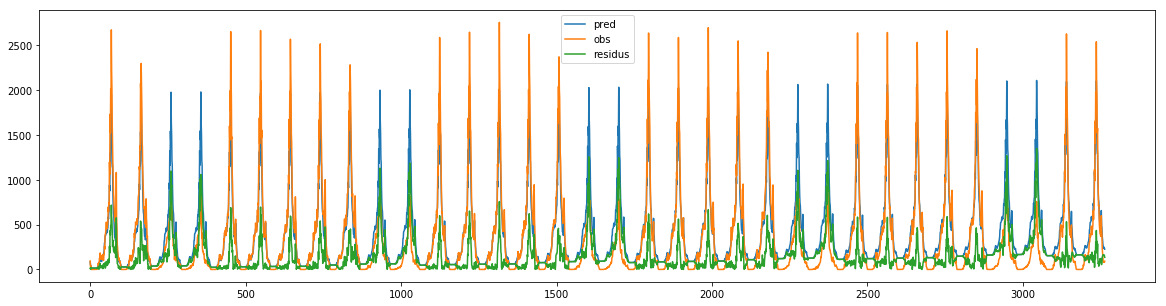

In [8]:
# Split data
start_train_list, end_train_list, end_val_list = ['2015-01-01'], ['2015-01-22'], ['2015-02-25']

# Configs 
configs = sarima_configs()

results = {}
cpt_split = 0

for start_train, end_train, end_val in zip(start_train_list, end_train_list, end_val_list):
    Yendog, exog, Yendog_name_list, exog_name_list = create_Yendog_exog(start_train, end_val, obs, fea)
    
    index_train = len(utils_date.get_list_common_date(start_train, end_train, obs, [fea]))
    Yendog_train, Yendog_val = Yendog[:index_train], Yendog[index_train:]
    exog_train, exog_val = exog[:index_train], exog[index_train:]
    
    results[cpt_split] = {}
    for ts_index, ts in enumerate(time_series):
        for cfg in configs:
            order, sorder, trend = cfg
            model = sarimax.SARIMAX(Yendog_train.flatten(), exog_train, order=order, seasonal_order=sorder, trend=trend,
                                    enforce_stationarity=False, enforce_invertibility=False)
            model_fit = model.fit(disp=1, maxiter=1)
            predictions = model_fit.predict(start=len(Yendog_train), end=len(Yendog_train)+len(Yendog_val)-1, exog=exog_val)
            
            fig,ax = plt.subplots(figsize=(20,5))
            plt.plot(predictions, label ='pred')
            plt.plot(Yendog_val.flatten(), label ='obs')
            plt.plot(np.abs(Yendog_val.flatten()-predictions), label='residus')
            plt.legend()
            plt.show()


In [ ]:
# Split data
start_train_list, end_train_list, end_val_list = ['2015-01-01'], ['2015-02-01'], ['2015-02-07']

# Configs 
configs = sarima_configs()

results = {}
cpt_split = 0

for start_train, end_train, end_val in zip(start_train_list, end_train_list, end_val_list):
    Yendog, exog, Yendog_name_list, exog_name_list = create_Yendog_exog(start_train, end_val, obs, fea)
    
    index_train = len(utils_date.get_list_common_date(start_train, end_train, obs, [fea]))
    Yendog_train, Yendog_val = Yendog[:index_train], Yendog[index_train:]
    exog_train, exog_val = exog[:index_train], exog[index_train:]
    
    results[cpt_split] = {}
    
    for ts_index, ts in enumerate(time_series):
        scores = grid_search(Yendog_train[:, ts_index], Yendog_val[:, ts_index],
                             exog_train, exog_val, configs, parallel = True)
        results[cpt_split][ts] = scores

    cpt_split+=1        
        
        
